In [7]:
import os, re, json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Dict, Any, List, Tuple, Optional

plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 10


TMP_IF_DIR = "/mnt/afs/jingjinhao/project/influence_function/outputs_mnist/_tmp_if"   # 只读这里
IMAGE_ROOT = "./"                 # multimodal 图像相对路径的根

def list_npz(tmp_dir: str) -> List[int]:
    ids = []
    for fn in os.listdir(tmp_dir):
        m = re.match(r"influences_test_(\d+)\.npz$", fn)
        if m:
            ids.append(int(m.group(1)))
    return sorted(ids)

def load_influence_npz(tmp_dir: str, test_id: int) -> Tuple[np.ndarray, np.ndarray, str]:
    path = os.path.join(tmp_dir, f"influences_test_{test_id}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    z = np.load(path)
    scores = z["scores"].astype(np.float32)
    train_ids = z["train_ids"].astype(np.int64)
    return scores, train_ids, path

def topk_helpful_harmful(scores: np.ndarray, train_ids: np.ndarray, k: int):
    order = np.argsort(scores)  # ascending
    helpful = train_ids[order[:k]].tolist()             # most negative
    harmful = train_ids[order[-k:]][::-1].tolist()      # most positive
    return helpful, harmful

def show_hist(scores: np.ndarray, title: str):
    plt.figure(figsize=(9,4))
    plt.hist(scores, bins=60)
    plt.title(title)
    plt.xlabel("Influence score")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

def show_scatter_rank(scores: np.ndarray, title: str, k: int = 2000):
    # 画 rank vs score（只取前k个点避免太慢）
    n = scores.shape[0]
    kk = min(k, n)
    idx = np.argsort(np.abs(scores))[-kk:]
    s = scores[idx]
    plt.figure(figsize=(9,4))
    plt.scatter(np.arange(len(s)), np.sort(np.abs(s)), s=4, alpha=0.7)
    plt.title(title)
    plt.xlabel("Rank (by |IF|)")
    plt.ylabel("|Influence score|")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

def read_jsonl_indexed(path: str) -> Dict[int, Dict[str, Any]]:
    """
    把 jsonl 读成 {id: record}。
    规则：
      - 优先用 record['id']，否则用行号当 id
    """
    out = {}
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            j = json.loads(line)
            rid = int(j["id"]) if "id" in j else i
            out[rid] = j
    return out

def pick_image_path(rec: Dict[str, Any]) -> Optional[str]:
    # 兼容你可能用过的字段名
    for k in ["image_path", "path", "image", "img_path", "filename"]:
        if k in rec and rec[k]:
            p = rec[k]
            if not os.path.isabs(p):
                p = os.path.join(IMAGE_ROOT, p)
            return p
    return None

def short_text(rec: Dict[str, Any], maxlen: int = 120) -> str:
    for k in ["text", "prompt", "question", "caption", "instruction", "answer", "label"]:
        if k in rec and rec[k] is not None:
            s = str(rec[k])
            return s[:maxlen] + ("..." if len(s) > maxlen else "")
    # fallback: keys
    return "keys=" + ",".join(list(rec.keys())[:10])

def show_image_card(title: str, img_path: Optional[str], subtitle: str = ""):
    plt.figure(figsize=(3.2,3.2))
    plt.axis("off")
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
    else:
        plt.text(0.5, 0.5, "(no image)", ha="center", va="center")
    plt.title(title, fontsize=10)
    if subtitle:
        plt.text(0.0, -0.1, subtitle, transform=plt.gca().transAxes, fontsize=8, va="top")
    plt.show()


In [8]:
test_ids = list_npz(TMP_IF_DIR)
print("Found influences npz:", len(test_ids))

# TEST_ID = test_ids[0] if test_ids else 0   # 你也可以手动改
TEST_ID = 9
K_SHOW = 6

scores, train_ids, path = load_influence_npz(TMP_IF_DIR, TEST_ID)
print("Loaded:", path)
print("scores:", scores.shape, "train_ids:", train_ids.shape)
print("min/mean/max:", float(scores.min()), float(scores.mean()), float(scores.max()))


Found influences npz: 47
Loaded: /mnt/afs/jingjinhao/project/influence_function/outputs_mnist/_tmp_if/influences_test_9.npz
scores: (55000,) train_ids: (55000,)
min/mean/max: -2.365931182232699e+17 53736458158080.0 1.9402195214113178e+17


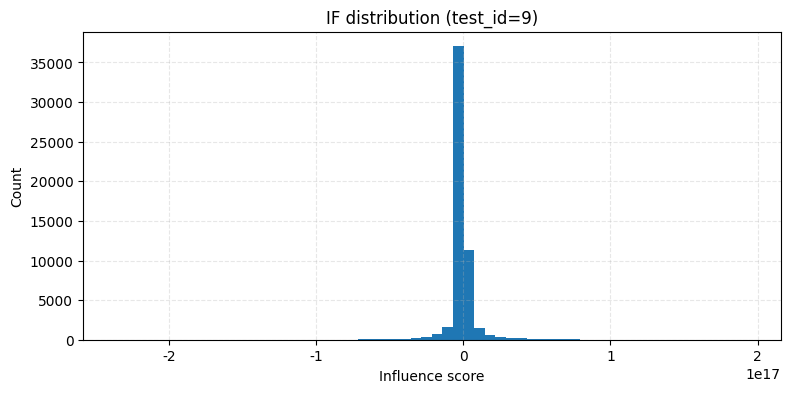

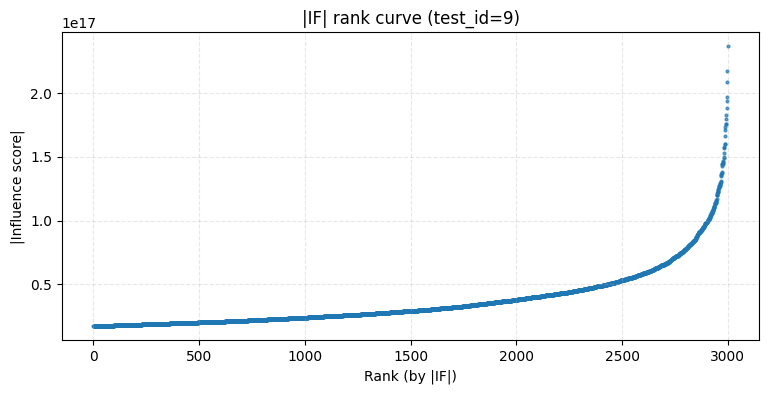

In [9]:
show_hist(scores, title=f"IF distribution (test_id={TEST_ID})")
show_scatter_rank(scores, title=f"|IF| rank curve (test_id={TEST_ID})", k=3000)


RAW_DIR = /mnt/afs/jingjinhao/project/influence_function/mnist/MNIST/raw
Test sample id = 10
Label = 0
Image shape = (28, 28) dtype=uint8 min=0 max=255


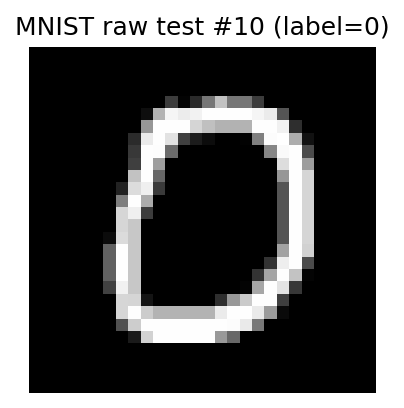

In [11]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

RAW_DIR = "/mnt/afs/jingjinhao/project/influence_function/mnist/MNIST/raw"
IMG_PATH = os.path.join(RAW_DIR, "t10k-images-idx3-ubyte")
LAB_PATH = os.path.join(RAW_DIR, "t10k-labels-idx1-ubyte")

def read_idx_images(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        if magic != 2051:
            raise ValueError(f"Bad magic for images: {magic} (expected 2051)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n, rows, cols)

def read_idx_labels(path: str) -> np.ndarray:
    with open(path, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        if magic != 2049:
            raise ValueError(f"Bad magic for labels: {magic} (expected 2049)")
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n)


images = read_idx_images(IMG_PATH)
labels = read_idx_labels(LAB_PATH)

img = images[TEST_ID]
label = int(labels[TEST_ID])

print(f"RAW_DIR = {RAW_DIR}")
print(f"Test sample id = {TEST_ID}")
print(f"Label = {label}")
print(f"Image shape = {img.shape} dtype={img.dtype} min={img.min()} max={img.max()}")

# Display image
plt.figure(figsize=(3,3), dpi=150)
plt.imshow(img, cmap="gray")
plt.title(f"MNIST raw test #{TEST_ID} (label={label})")
plt.axis("off")
plt.show()


=== Helpful (most negative) ===
train_id= 53507  label=5  score=-4.744384e+12
train_id= 27181  label=2  score=-4.117321e+12
train_id=  6885  label=1  score=-4.038733e+12
train_id= 41998  label=7  score=-3.997470e+12
train_id= 36214  label=5  score=-3.979568e+12
train_id= 26066  label=5  score=-3.956375e+12


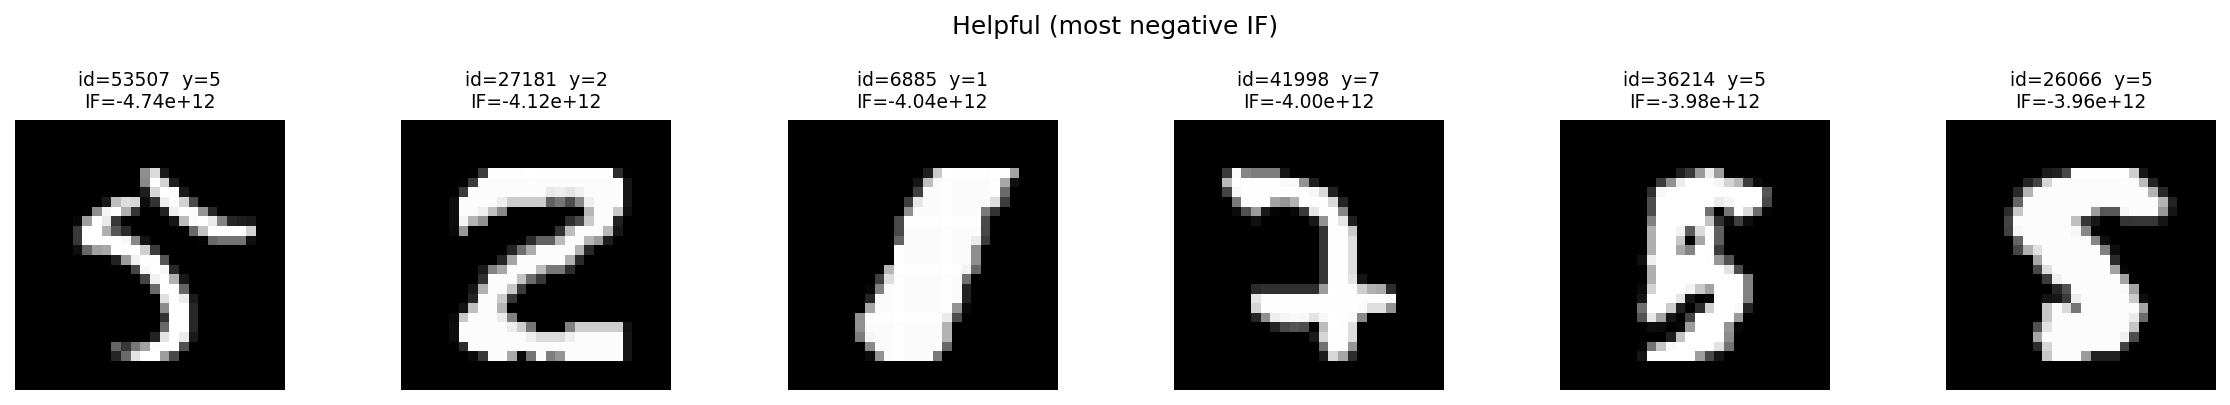


=== Harmful (most positive) ===
train_id= 54178  label=8  score= 5.424230e+12
train_id= 11796  label=8  score= 4.992680e+12
train_id=  2958  label=8  score= 4.488308e+12
train_id=  6066  label=8  score= 4.033475e+12
train_id=  4058  label=8  score= 3.951682e+12
train_id= 52070  label=8  score= 3.900443e+12


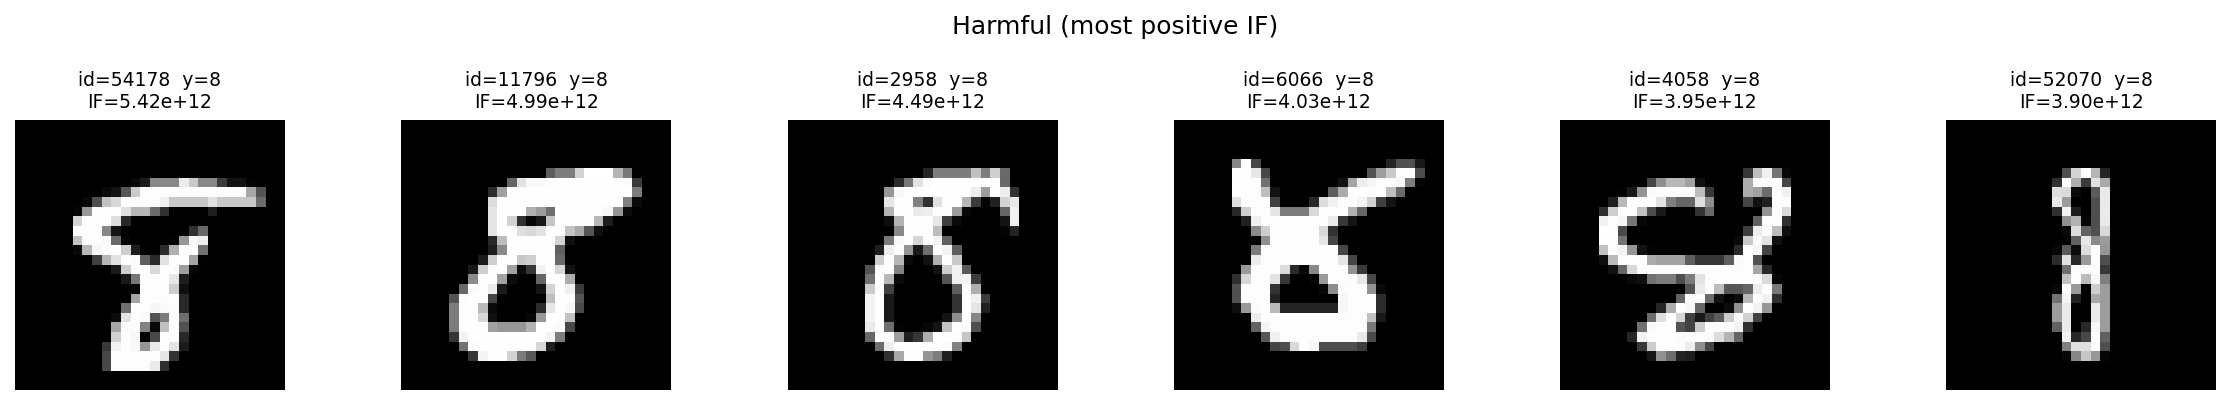

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms

MNIST_ROOT = "/mnt/afs/jingjinhao/project/influence_function/mnist"  # 注意：不是 .../MNIST/raw
K_SHOW = 6

# 加载 MNIST train 集（不下载，直接读你本地 raw）
mnist_train = MNIST(
    root=MNIST_ROOT,
    train=True,
    download=False,
    transform=transforms.ToTensor(),
)

helpful_ids, harmful_ids = topk_helpful_harmful(scores, train_ids, K_SHOW)

def score_of(tid: int) -> float:
    idx = np.where(train_ids == tid)[0]
    return float(scores[idx[0]]) if len(idx) else float("nan")

def show_samples(title: str, ids: list, ncols: int = 6):
    n = len(ids)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(2.6*ncols, 2.6*nrows), dpi=150)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])

    fig.suptitle(title, y=1.02, fontsize=12)

    for i, tid in enumerate(ids):
        r, c = divmod(i, ncols)
        ax = axes[r, c]
        ax.axis("off")

        # MNIST 按 index 取样本：tid 就是 train_id/index
        img, label = mnist_train[int(tid)]  # img: [1,28,28] tensor
        ax.imshow(img.squeeze(0).numpy(), cmap="gray")

        sc = score_of(int(tid))
        ax.set_title(f"id={tid}  y={int(label)}\nIF={sc:.2e}", fontsize=9)

        # 同时在 stdout 打一行“数据”
        print(f"train_id={tid:6d}  label={int(label)}  score={sc: .6e}")

    # 多余格子隐藏
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

print("=== Helpful (most negative) ===")
show_samples("Helpful (most negative IF)", helpful_ids, ncols=K_SHOW)

print("\n=== Harmful (most positive) ===")
show_samples("Harmful (most positive IF)", harmful_ids, ncols=K_SHOW)


In [ ]:
# 如果你是 MNIST，通常没有 jsonl，也没有 image_path，所以这一格可以跳过。
TRAIN_JSONL = "./data/train_data_new.jsonl"
TEST_JSONL  = "./data/test_data_new.jsonl"

if os.path.exists(TRAIN_JSONL) and os.path.exists(TEST_JSONL):
    train_map = read_jsonl_indexed(TRAIN_JSONL)
    test_map  = read_jsonl_indexed(TEST_JSONL)

    print("train jsonl size:", len(train_map))
    print("test  jsonl size:", len(test_map))

    test_rec = test_map.get(TEST_ID)
    if test_rec is None:
        print(f"[WARN] test_id={TEST_ID} not found in test jsonl keys.")
    else:
        show_image_card(
            title=f"TEST id={TEST_ID}",
            img_path=pick_image_path(test_rec),
            subtitle=short_text(test_rec, 180),
        )

    print("\n--- Helpful samples ---")
    for tid in helpful_ids:
        rec = train_map.get(int(tid))
        if rec is None:
            print(f"[WARN] train_id={tid} not found in train jsonl")
            continue
        show_image_card(
            title=f"Helpful train_id={tid}  score={score_of(tid):.3e}",
            img_path=pick_image_path(rec),
            subtitle=short_text(rec, 180),
        )

    print("\n--- Harmful samples ---")
    for tid in harmful_ids:
        rec = train_map.get(int(tid))
        if rec is None:
            print(f"[WARN] train_id={tid} not found in train jsonl")
            continue
        show_image_card(
            title=f"Harmful train_id={tid}  score={score_of(tid):.3e}",
            img_path=pick_image_path(rec),
            subtitle=short_text(rec, 180),
        )
else:
    print("[INFO] TRAIN_JSONL / TEST_JSONL not found. Skipping multimodal sample visualization.")


In [21]:
# 快速扫前 N 个 test，打印统计量
N = min(10, len(test_ids))
for tid in test_ids[:N]:
    s, tr, _ = load_influence_npz(TMP_IF_DIR, tid)
    print(f"test_id={tid:4d}  mean={s.mean(): .3e}  std={s.std(): .3e}  min={s.min(): .3e}  max={s.max(): .3e}")


test_id=   0  mean=-8.676e+13  std= 1.407e+16  min=-2.080e+17  max= 2.030e+17
